In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import warnings
warnings.filterwarnings("ignore")

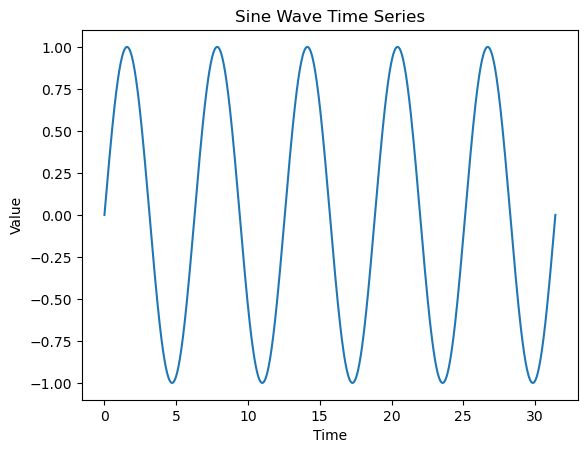

In [10]:
# 生成正弦波数据
seq_length = 20  # 每个样本的序列长度
data_size = 1000  # 总数据量
t = np.linspace(0, 10 * np.pi, data_size)  # 时间轴
data = np.sin(t)  # 正弦波数据

# 可视化数据
plt.plot(t, data)
plt.title("Sine Wave Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [11]:
# 将数据转换为PyTorch张量
data = torch.FloatTensor(data).view(-1)

# 创建输入和输出序列
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]  # 输入序列
        y = data[i + seq_length]    # 输出值（下一个时间步的值）
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# 创建训练数据
X, y = create_sequences(data, seq_length)

In [12]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  # RNN层
        self.fc = nn.Linear(hidden_size, output_size)  # 全连接层

    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        
        # RNN前向传播
        out, _ = self.rnn(x, h0)
        
        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# 初始化模型
input_size = 1  # 输入特征的维度（时间序列的每个时间步是一个标量）
hidden_size = 32  # 隐藏层的神经元数量
output_size = 1  # 输出维度（预测下一个时间步的值）
model = SimpleRNN(input_size, hidden_size, output_size)

In [13]:
criterion = nn.MSELoss()  # 均方误差损失
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam优化器

In [14]:
num_epochs = 100
batch_size = 32

# 创建数据加载器
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 训练循环
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # 前向传播
        outputs = model(batch_X.unsqueeze(-1))  # 增加一个维度以匹配RNN输入格式
        loss = criterion(outputs, batch_y)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.3122
Epoch [20/100], Loss: 0.4674
Epoch [30/100], Loss: 0.5712
Epoch [40/100], Loss: 0.4048
Epoch [50/100], Loss: 0.5880
Epoch [60/100], Loss: 0.5458
Epoch [70/100], Loss: 0.5503
Epoch [80/100], Loss: 0.6201
Epoch [90/100], Loss: 0.6212
Epoch [100/100], Loss: 0.6896


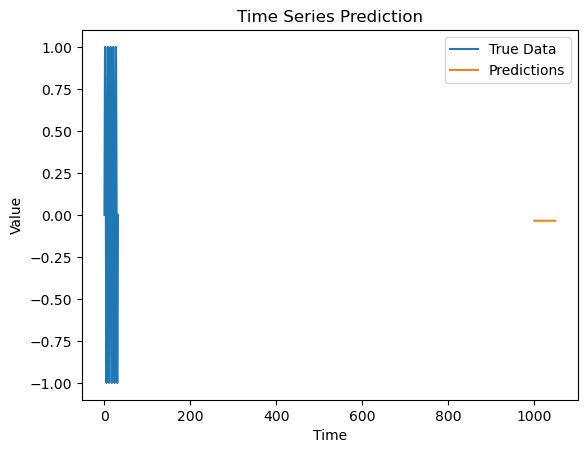

In [15]:
# 将模型设置为评估模式
model.eval()

# 使用最后一段序列作为输入
test_input = X[-1].unsqueeze(0).unsqueeze(-1)  # 形状: (1, seq_length, 1)

# 预测未来值
future_steps = 50
predictions = []
with torch.no_grad():
    for _ in range(future_steps):
        pred = model(test_input)  # 输出形状: (1, 1)
        pred = pred.unsqueeze(-1)  # 增加特征维度，形状: (1, 1, 1)
        predictions.append(pred.item())
        
        # 更新输入序列
        test_input = torch.cat((test_input[:, 1:, :], pred), dim=1)  # 拼接，形状: (1, seq_length, 1)

# 可视化预测结果
plt.plot(t, data, label="True Data")
plt.plot(np.arange(len(data), len(data) + future_steps), predictions, label="Predictions")
plt.title("Time Series Prediction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()